In [3]:
#import python packages
import pandas as pd

In [7]:
#import the data file
loan_df = pd.read_csv('/content/loan_data_nov2023.csv')

loan_df.head()

,default,amount,interest,grade,years,ownership,income,age
0,0,5000,10.65,B,10.0,RENT,24000.0,33
1,0,2400,10.99,C,25.0,RENT,12252.0,31
2,0,10000,13.49,C,13.0,RENT,49200.0,24
3,0,5000,10.99,A,3.0,RENT,36000.0,39
4,0,3000,10.99,E,9.0,RENT,48000.0,24


##Correlation Matrix

<ipython-input-8-27982f7d23e4>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = loan_df.corr()


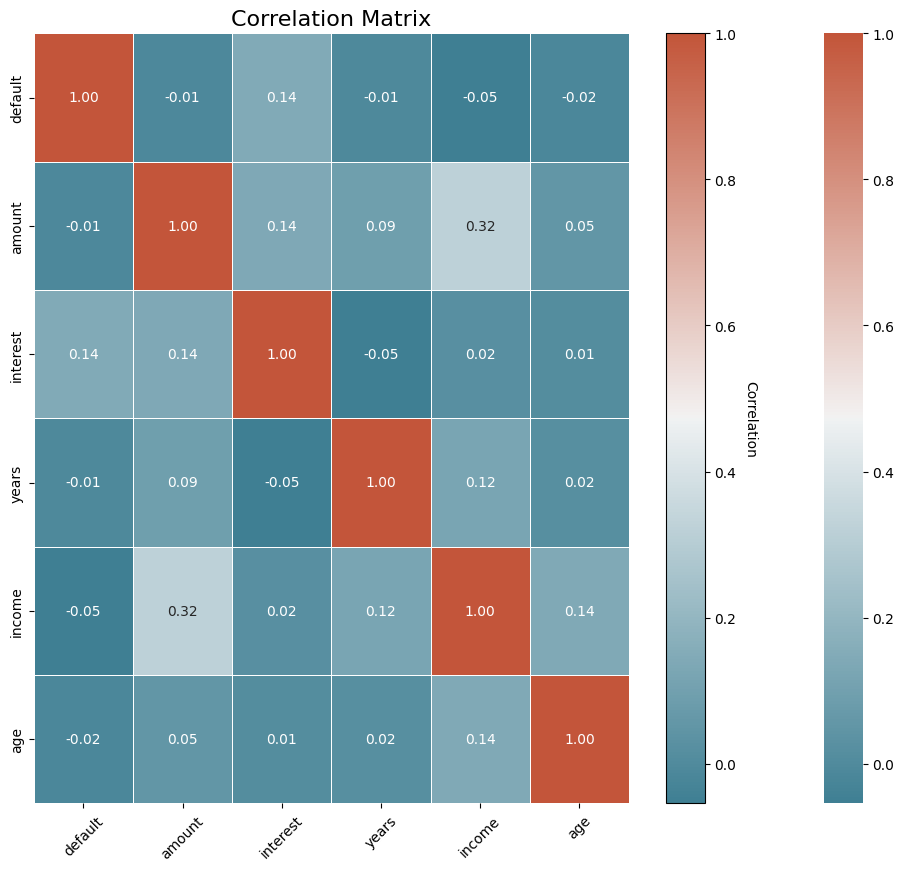

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming loan_data is your DataFrame
# Calculate the correlation matrix
correlation_matrix = loan_df.corr()

# Set up a diverging color map for better visualization
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Set up the heatmap
plt.figure(figsize=(12, 10))

# Plot the heatmap with annotations, using the diverging color map and displaying values with two decimal places
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=.5)

# Customize the plot with a title
plt.title('Correlation Matrix', fontsize=16)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a color bar for reference
cbar = heatmap.figure.colorbar(heatmap.collections[0])
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Display the plot
plt.show()


##Data Standardization

In [9]:
import torch
import pandas as pd

# Assuming loan_data is your DataFrame
numerical_columns = loan_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = ['grade', 'ownership']  # assuming these are your categorical columns

# Extract numerical features
numerical_features = loan_df[numerical_columns].values

# Convert numerical features to PyTorch tensor
numerical_tensor = torch.tensor(numerical_features, dtype=torch.float32)

# Calculate mean and standard deviation
mean = numerical_tensor.mean(dim=0)
std = numerical_tensor.std(dim=0)

# Standardize numerical features using PyTorch
numerical_scaled_tensor = (numerical_tensor - mean) / std

# Convert the scaled tensor back to a DataFrame
numerical_scaled_df = pd.DataFrame(numerical_scaled_tensor.numpy(), columns=numerical_columns, index=loan_df.index)

# Combine the scaled numerical features with the categorical features
scaled = pd.concat([numerical_scaled_df, loan_df[categorical_columns]], axis=1)
scaled.head()


,default,amount,interest,years,income,age,grade,ownership
0,-0.353219,-0.726447,-0.114625,0.593694,-0.806804,0.855885,B,RENT
1,-0.353219,-1.137614,-0.004258,2.868631,-1.027411,0.533024,C,RENT
2,-0.353219,0.064258,0.807263,1.048682,-0.333593,-0.596989,C,RENT
3,-0.353219,-0.726447,-0.004258,-0.467943,-0.581466,1.824468,A,RENT
4,-0.353219,-1.042729,-0.004258,0.442032,-0.356127,-0.596989,E,RENT


In [10]:
import torch
import pandas as pd

# Assuming loan_data_scaled is your DataFrame after standardization
categorical_columns = ['grade', 'ownership']

# One-hot encoding the categorical variables using PyTorch
encoded_tensors = [torch.nn.functional.one_hot(
    torch.tensor(scaled[column].astype('category').cat.codes, dtype=torch.int64),
    num_classes=scaled[column].nunique()
) for column in categorical_columns]

# Concatenate the encoded tensors along the last dimension
encoded_data = torch.cat(encoded_tensors, dim=-1)

# Convert the encoded tensor to a DataFrame
encoded_df = pd.DataFrame(encoded_data.numpy(), columns=[f'{column}_{i}' for column in categorical_columns for i in range(scaled[column].nunique())])

# Concatenate the encoded data with the original DataFrame
loan_data_encoded = pd.concat([scaled, encoded_df], axis=1)

# Dropping the original categorical columns
loan_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the first few rows of the updated dataset
loan_data_encoded.head()


,default,amount,interest,years,income,age,grade_0,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,ownership_0,ownership_1,ownership_2,ownership_3
0,-0.353219,-0.726447,-0.114625,0.593694,-0.806804,0.855885,0,1,0,0,0,0,0,0,0,0,1
1,-0.353219,-1.137614,-0.004258,2.868631,-1.027411,0.533024,0,0,1,0,0,0,0,0,0,0,1
2,-0.353219,0.064258,0.807263,1.048682,-0.333593,-0.596989,0,0,1,0,0,0,0,0,0,0,1
3,-0.353219,-0.726447,-0.004258,-0.467943,-0.581466,1.824468,1,0,0,0,0,0,0,0,0,0,1
4,-0.353219,-1.042729,-0.004258,0.442032,-0.356127,-0.596989,0,0,0,0,1,0,0,0,0,0,1


##Train & Test Data Splitting

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming loan_data_encoded is your DataFrame after preprocessing

# Convert DataFrame to PyTorch tensors
X = torch.tensor(loan_data_encoded.drop(['amount'], axis=1).values, dtype=torch.float32)
y = torch.tensor(loan_data_encoded['amount'].values, dtype=torch.float32).view(-1, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader for handling batches during training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
model = LinearRegressionModel(X_train.shape[1])

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Predicting the loan amounts for the test set
with torch.no_grad():
    y_pred = model(X_test)

# Convert predictions back to numpy arrays for evaluation
y_test_np = y_test.numpy()
y_pred_np = y_pred.numpy()

# Evaluating the model
mse = mean_squared_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print("MSE: ", mse)
print("R^2: ", r2)


MSE:  0.85007066
R^2:  0.14958065466921466


##Label Encoding

In [12]:

from sklearn.preprocessing import LabelEncoder

# Reloading the dataset and dropping the 'default' column
loan_df = pd.read_csv('/content/loan_data_nov2023.csv').drop('default', axis=1)

# Creating separate LabelEncoder instances for 'grade' and 'ownership'
label_encoder_grade = LabelEncoder()
label_encoder_ownership = LabelEncoder()

# Applying label encoding to the 'grade' and 'ownership' columns
loan_df['grade_encoded'] = label_encoder_grade.fit_transform(loan_df['grade'])
loan_df['ownership_encoded'] = label_encoder_ownership.fit_transform(loan_df['ownership'])

# Extracting the mappings for 'grade'
grade_mapping = dict(zip(label_encoder_grade.classes_, label_encoder_grade.transform(label_encoder_grade.classes_)))

# Extracting the mappings for 'ownership'
ownership_mapping = dict(zip(label_encoder_ownership.classes_, label_encoder_ownership.transform(label_encoder_ownership.classes_)))

# Display the mappings
print("Grade Mapping:", grade_mapping)
print("Ownership Mapping:", ownership_mapping)

# Displaying the first few rows of the updated DataFrame
loan_df.head()


Grade Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
Ownership Mapping: {'MORTGAGE': 0, 'OTHER': 1, 'OWN': 2, 'RENT': 3}


,amount,interest,grade,years,ownership,income,age,grade_encoded,ownership_encoded
0,5000,10.65,B,10.0,RENT,24000.0,33,1,3
1,2400,10.99,C,25.0,RENT,12252.0,31,2,3
2,10000,13.49,C,13.0,RENT,49200.0,24,2,3
3,5000,10.99,A,3.0,RENT,36000.0,39,0,3
4,3000,10.99,E,9.0,RENT,48000.0,24,4,3


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Splitting the dataset into training and testing sets
X = loan_df.drop(['amount', 'grade', 'ownership'], axis=1)
y = loan_df['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()

# Diagnose and handle any issues in the data
try:
    model.fit(X_train, y_train)
except Exception as e:
    print(f"Error: {e}")

# Evaluating the model
y_pred = model.predict(X_test)
mse_label = mean_squared_error(y_test, y_pred)
r2_label = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse_label)
print("R-Squared: ", r2_label)


Mean Squared Error:  34351603.590951
R-Squared:  0.14056197470603116
